In [546]:
from os import path
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
from abacat import SequenceFile
from scipy.stats import linregress, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Ellipse
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn-dark-palette')

In [547]:
# Importing data
df = pd.read_csv("../data/metadata.csv")
df = df[~df['checkm_completeness'].isna()]
df = df[df['quality_filter']]

# Format columns
def fill_rank(row, rank='genus'):
    ranks = {
        "genus": 0,
        "species": 1,
        "strain": 2
    }
    label = ""
    if row['is_synecho']:
        if ranks[rank] < 2:
            label = str(row['label'].split("_")[ranks[rank]])
        if len(label) > 1:
            pass
        else:
            label = str(row[f'gtdb_{rank}'])
    else:
        label += str(row[f'gtdb_{rank}'])
    return label

# Formatting columns
df["gc"] = df["gc"] * 100
df['new_genus'] = df.apply(lambda row: 'Other cyanobacteria' if row['is_synecho'] == False else row['new_genus'], axis=1)

In [548]:
def main(data, data_, figsize=(15,15), axis_lim=((1,7), (30,70)), palette='deep', **kwargs):
    
    # Setting general attributes
    sns.set_palette(palette)
    markers = ['o', 'v', '^', '<', 's', '>',] * 5 # other marker choices are: 'sDdPX'
    
    # Fig instance
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows=3, ncols=2, height_ratios=[1,1,1], wspace=0.05)
    
    # First axis
    ax0 = fig.add_subplot()
    if axis_lim:
        ax0.set_xlim(axis_lim[0])
        ax0.set_ylim(axis_lim[1])

    # Data formatting
    data = data.rename(columns={'new_genus': "Genus"})
    data["no_genus"] = data["no_genus"].astype(str)
    data["Genus"] = data.apply(lambda row: row["Genus"] + f" ({row['no_genus']})", axis=1)
    
    # Plotting method
    sns.scatterplot(x='megabases', y='gc', data=data, alpha=0.7,
                    hue=data["Genus"], style=data["Genus"], hue_order=data["Genus"].value_counts().index,
                    s=100, ax=ax0, zorder=1, markers=markers)
    
    if 'data_' in kwargs.keys():
        sns.scatterplot(x='megabases', y='gc', data=kwargs['data_'],
                        color='lightgray', alpha=0.6, s=100, ax=ax0, zorder=0)
    
    if 'legend_pos' in kwargs.keys():
        plt.legend(loc=kwargs['legend_pos'])
    
    if 'save' in kwargs.keys():
        plt.savefig(kwargs['save'], dpi=600)
    
    plt.show()

In [559]:
def main2(data, data_, figsize=(15,15), axis_lim=((1,7), (30,70)), palette='deep', **kwargs):
    
    # Setting general attributes
    sns.set_palette(palette)
    markers = ['o', 'v', '^', '<', 's', '>',] * 5 # other marker choices are: 'sDdPX'
    
    # Fig instance
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows=3, ncols=2, height_ratios=[1,1,1], wspace=0.05)

    # Data formatting
    data = data.copy()
    data['no_genus'] = data.groupby('new_genus')['new_genus'].transform('count').map(int, na_action="ignore")
    data = data.rename(columns={'new_genus': "Genus"})
    data["Genus"] = data["Genus"].apply(lambda s: r"${}$".format(s))
    data["Genus"] = data.apply(lambda row: row["Genus"] + f" ({str(row['no_genus'])})", axis=1)
    data = data.sort_values("no_genus", ascending=False)
    
    # First axis - scatterplot
    ax0 = fig.add_subplot(gs[:2, :])
    if axis_lim:
        ax0.set_xlim(axis_lim[0])
        ax0.set_ylim(axis_lim[1])

    sns.scatterplot(x='megabases', y='gc', data=data, alpha=0.7,
                    hue=data["Genus"], style=data["Genus"], hue_order=data["Genus"].value_counts().index,
                    s=100, ax=ax0, zorder=1, markers=markers)
    
    sns.scatterplot(x='megabases', y='gc', data=data_,
                        color='lightgray', alpha=0.6, s=100, ax=ax0, zorder=0)
        
    # Second axis - size plot
    ax1 = fig.add_subplot(gs[2, 0])
    sns.boxplot(
        y="Genus",
        x="megabases",
        data=data,
        boxprops=dict(alpha=.5),
        ax=ax1)
    sns.swarmplot(
        y="Genus",
        x="megabases",
        data=data,
        hue="Genus",
        alpha=0.7,
        zorder=0,
        ax=ax1)
    
    # Third axis - GC plot
    # GC plot
    ax2 = fig.add_subplot(gs[2, 1], sharey=ax1)
    sns.boxplot(
        y="Genus",
        x="gc",
        data=data,
        boxprops=dict(alpha=.5),
        ax=ax2)
    sns.swarmplot(
        y="Genus",
        x="gc",
        data=data,
        hue="Genus",
        alpha=0.7,
        zorder=0,
        ax=ax2)
    
    # Hiding legends
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax1.legend().remove()
    ax2.legend().remove()
    ax1.grid(False)
    ax2.grid(False)

    # Fixing labels
    ax0.set_xlabel("Size (Mbp)")
    ax0.set_ylabel("GC content (%)")
    ax1.set_xlabel("Size (Mbp)")
    ax1.set_ylabel("")
    ax2.set_xlabel("GC content (%)")
    ax2.set_ylabel("")
    
    # Other kwargs
    if 'legend_pos' in kwargs.keys():
        plt.legend(loc=kwargs['legend_pos'])
    
    if 'save' in kwargs.keys():
        plt.savefig(kwargs['save'], dpi=600)
    
    plt.show()

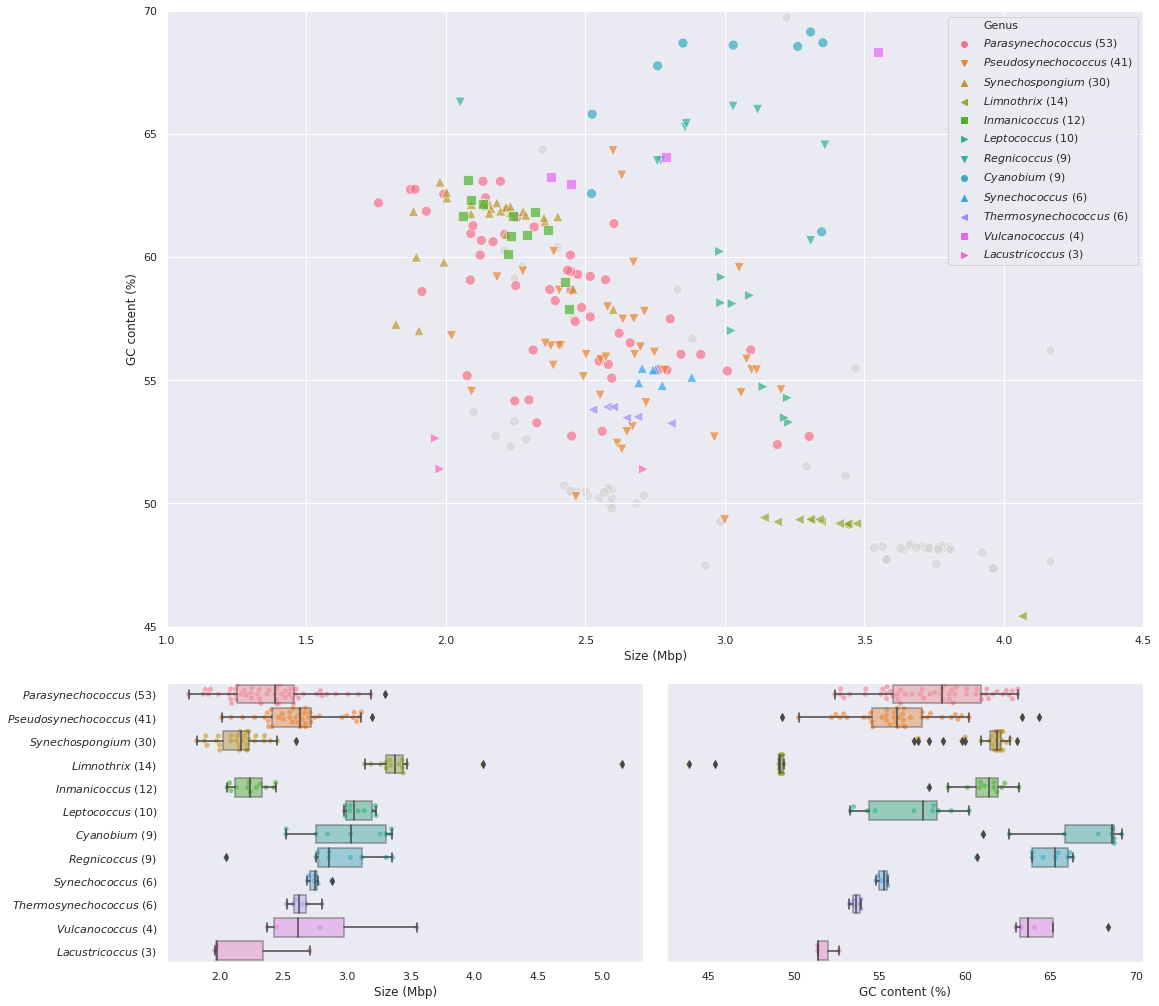

In [563]:
# Our draft
df_ = df[df['quality_filter']].copy()

df_['no_genus'] = df_.groupby('new_genus')[
    'new_genus'].transform('count').map(int, na_action="ignore")

data = df_[(df_['is_synecho']) &
           ~(df_['new_genus'].isin(("GCA", "PCC-7336"))) &
           (df_['no_genus'] > 1)].copy()
data_ = df_[~df_['is_synecho']].copy()

models = []

for dataframe in (data, data_):
    model = linregress(dataframe['checkm_completeness'], dataframe['megabases'])
    models.append(model)
    dataframe['megabases'] = dataframe.apply(lambda row: 100 *
                                   row['megabases'] / row['checkm_completeness'] if
                                   row['checkm_completeness'] < 100 else row['megabases'], axis=1)

main2(data=data, data_=data_, figsize=(17.5,17.5), axis_lim=((1,4.5), (45, 70)),)
      #save="../data/plots/gc_size/gc_size2_adjusted_simply_no_singletons.png")

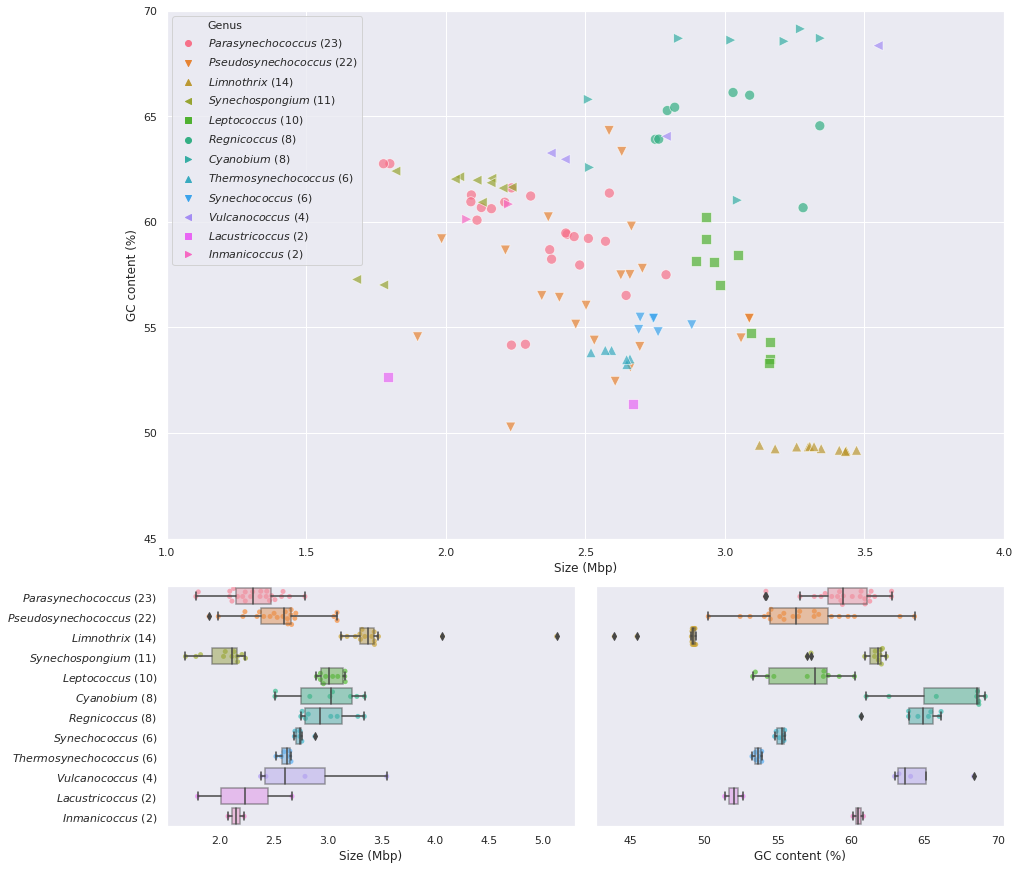

In [552]:
# Without adjusting genome size to completeness
df_ = df[df['quality_filter'] & (df['checkm_completeness'] > 85)].copy()

df_['no_genus'] = df_.groupby('new_genus')[
    'new_genus'].transform('count').map(int, na_action="ignore")

data = df_[(df_['is_synecho']) &
           ~(df_['new_genus'].isin(("GCA", "PCC-7336"))) &
           (df_['no_genus'] > 1) & 
           (df_['checkm_completeness'] > 90)]


data_ = df_[~df_['is_synecho']]

main2(data=data, data_=data_, figsize=(15,15), axis_lim=((1,4), (45, 70)), save="../data/plots/gc_size/gc_size_2_90_completeness_no_singletons.png")